## Import Libraries

In [22]:
!pip install ibm-watson
!pip install seaborn
!pip install pandas
!pip install tqdm
!pip install matplotlib

You should consider upgrading via the '/Users/callumkemp/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/callumkemp/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/callumkemp/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/callumkemp/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/callumkemp/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
from IPython.display import HTML
from ibm_watson import AssistantV2
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import pandas as pd    
import json
import time
from tqdm import tqdm
import seaborn as sns
import matplotlib as plt
from datetime import date
import statistics

today = date.today()

## API Details

In [3]:
authenticator = IAMAuthenticator('')
assistant = AssistantV2(
    version='2020-04-01',
    authenticator = authenticator
)
assistant.set_service_url('')
assistant_id = ''

In [4]:
ResponseList = []
IntentList = []
ConfidenceList = []
ExpectedList = []
SecondIntent = []
SecondConfidence = []



MatchList = []
ConfidenceChangeList = []


LatestHistoricMatchConfidence = []
LatestHistoricUnmatchConfidence = []
LatestHistoricAverageConfidence = []
LatestHistoricCorrectResponse = []
LatestHistoricDate = []




RegressionFile = pd.read_csv('regression.csv')
HistoricDF = pd.read_csv('RegressionLog.csv')

## Load the last set of results and questions into a list

In [5]:
QuestionList = RegressionFile['Question'].tolist()
ExpectedList = RegressionFile['Expected'].tolist()
ScoreList = RegressionFile['Confidence'].tolist()

## Send questions to Watson and log the response

In [6]:
def Sender():
    response = assistant.message_stateless(
    assistant_id,
    input={
        'message_type': 'text',
        'text': x,
     'options': {
            'return_context': True
        }
    },
    context={
        'skills': {
            'main skill': {
                'user_defined': {
                    'ConfidenceTester': 'Yes'
                }
            }
        }
    }
).get_result()
    pbar.update(1) #Updates the progressbar
    IntentList.append((response['context']['skills']['main skill']['user_defined']['Intent']['intent']))
    ConfidenceList.append((response['context']['skills']['main skill']['user_defined']['Intent']['confidence']))
    SecondIntent.append((response['context']['skills']['main skill']['user_defined']['Intent1']['intent']))
    SecondConfidence.append((response['context']['skills']['main skill']['user_defined']['Intent1']['confidence']))

## Loop through and show progress bar

In [7]:
pbar = tqdm(total=len(QuestionList),desc="Percentage complete") 
for x in QuestionList:
    Sender()
pbar.close()

Percentage complete: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


## Case Match

In [8]:
IntentList = [item.lower() for item in IntentList] 
ExpectedList = [item.lower() for item in ExpectedList]
UniqueList = list(dict.fromkeys(IntentList)) # List all the unique names for each intent in here.

## Differential Calculation

In [9]:
DifferentialDict = {
    "Confidence 1": (ConfidenceList),
    "Confidence 2":(SecondConfidence)
    
}

DifferentialDF = pd.DataFrame(DifferentialDict)

Differential = DifferentialDF["Confidence 1"] - DifferentialDF["Confidence 2"]

DifferentialDict = {
    "Intent 1": (IntentList),
    "Confidence 1": (ConfidenceList),
    "Intent 2": (SecondIntent),
    "Confidence 2":(SecondConfidence),
    "Difference": (Differential)
}

DifferentialDF = pd.DataFrame(DifferentialDict)
Difference1 = statistics.mean(ConfidenceList)
Difference2 = statistics.mean(SecondConfidence)

'''Calculate Clarity for the log'''
Difference1 = statistics.mean(ConfidenceList)
Difference2 = statistics.mean(SecondConfidence)
Clarity = round((Difference1 - Difference2) * 100, 2)

## Low Confidence and Match count

In [10]:
if len(IntentList) == len(ExpectedList):
    for i in range(len(IntentList)):
        if IntentList[i] == ExpectedList[i]:
         MatchList.append('Matched')
        else: 
         MatchList.append('Unmatched')

CorrectCount = MatchList.count("Matched")
IncorrectCount = MatchList.count("Unmatched")

LowConf = len([1 for i in ConfidenceList if i < 0.2])

Total = round(CorrectCount / len(MatchList) * 100,2)

NumExamples = len(MatchList)

## Calculate the Averages

In [11]:
RegressionFile['MatchList'] = MatchList
RegressionFile['ConfidenceList'] = ConfidenceList #Look at this before release
MatchedQuestion = RegressionFile[(RegressionFile['MatchList'] == 'Matched')]
UnmatchedQuestion = RegressionFile[(RegressionFile['MatchList'] == 'Unmatched')]
AverageForMatched = round(MatchedQuestion['ConfidenceList'].mean() * 100,2)
AverageForUnmatched = round(UnmatchedQuestion['ConfidenceList'].mean() *100,2)
AverageConfidence = round(RegressionFile['ConfidenceList'].mean() *100,2)


LatestHistoricMatchConfidence.append(AverageForMatched)
LatestHistoricUnmatchConfidence.append(AverageForUnmatched)
LatestHistoricAverageConfidence.append(AverageConfidence)
LatestHistoricCorrectResponse.append(Total)
LatestHistoricDate.append(today)

In [12]:
LatestDict = {'Match Confidence': (LatestHistoricMatchConfidence),
              'Unmatched Confidence':(LatestHistoricUnmatchConfidence),
              'Average Confidence':(LatestHistoricAverageConfidence),
              'Correct Response %':(LatestHistoricCorrectResponse),
              'Clarity':(Clarity),
              'Low Confidence':(LowConf),
              'Number of Examples': (NumExamples),
              'Date':(LatestHistoricDate)
} 

LatestDF = pd.DataFrame(LatestDict)


DifferentialDict = {
    "Intent 1": (IntentList),
    "Confidence 1": (ConfidenceList),
    "Intent 2": (SecondIntent),
    "Confidence 2":(SecondConfidence),
    "Difference": (Differential),
    'Matched': (NumExamples)
    
}

DifferentialDF = pd.DataFrame(DifferentialDict)
DifferentialDF[DifferentialDF.Matched != 'Matched']
RegressionLogDF = pd.concat([HistoricDF,LatestDF], join="inner",)

/Users/callumkemp/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## Print the last 5 results

In [13]:
RegressionLogDF.tail(5)

,Match Confidence,Unmatched Confidence,Average Confidence,Correct Response %,Clarity,Number of Examples,Low Confidence,Date
3,76.27,0.0,76.27,100.0,0.00,0,0,08/01/2021
4,76.27,0.0,76.27,100.0,0.00,0,0,10/01/2021
5,76.27,0.0,76.27,100.0,0.00,0,0,11/02/2021
6,77.51,NaN,77.51,100.0,49.67,50,0,2021-02-11
0,77.51,NaN,77.51,100.0,49.67,50,0,2021-02-11


## Confusion Matrix

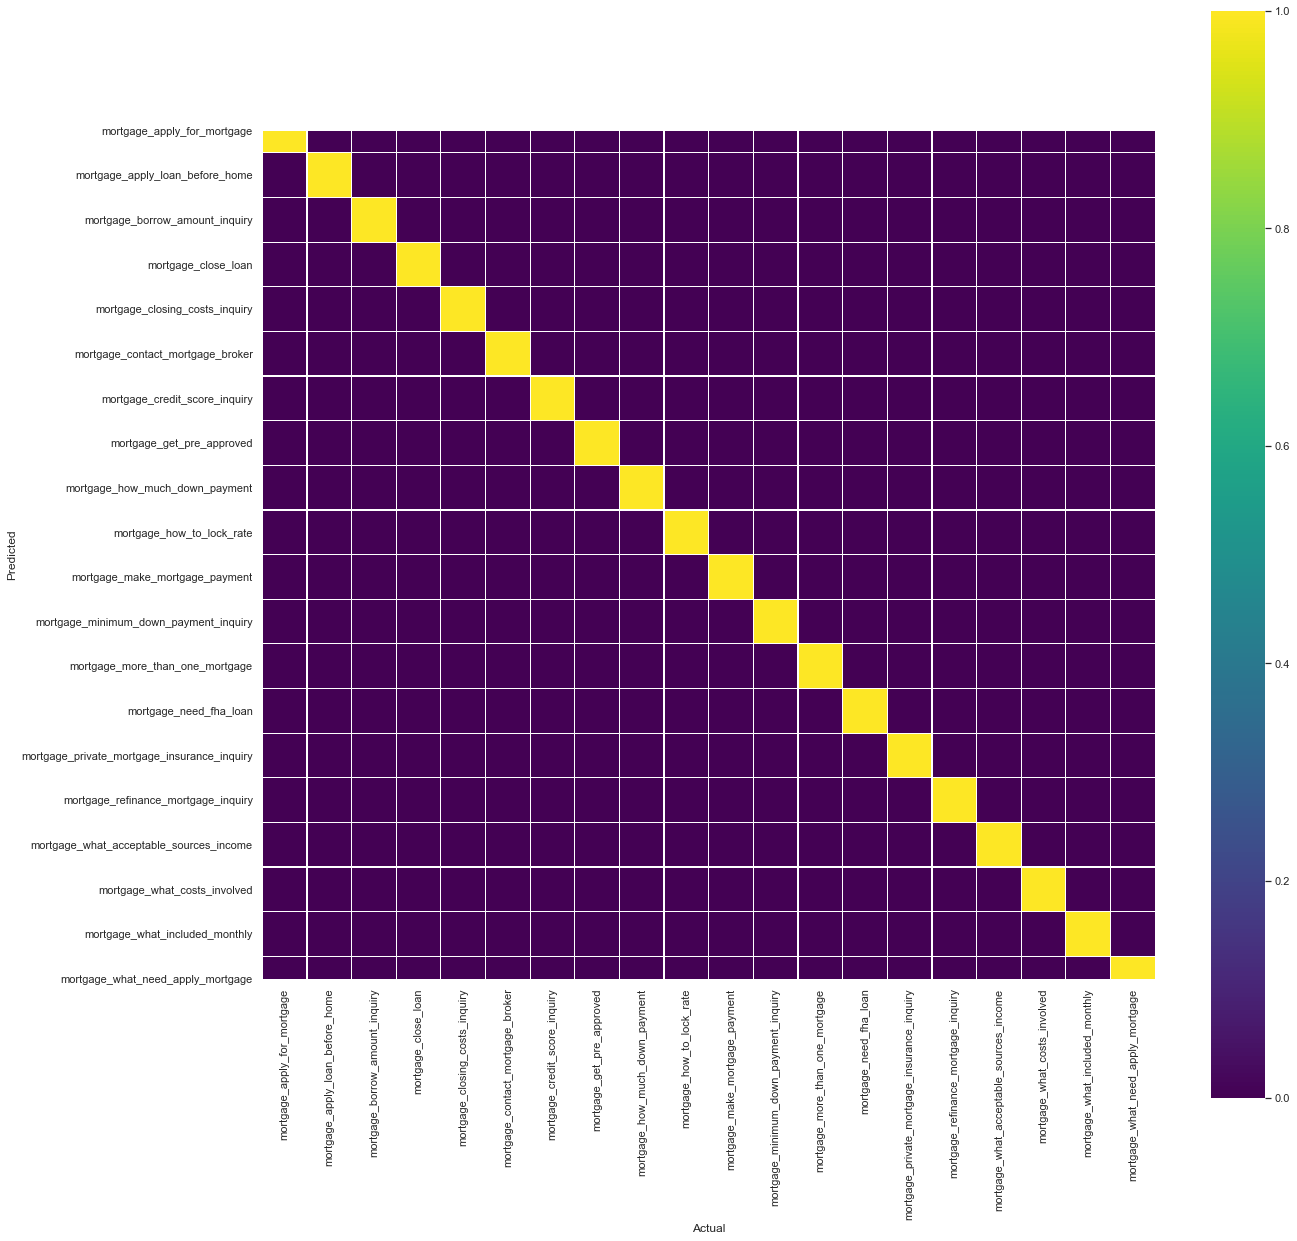

In [21]:
ConfusionMatrixData = {'x_Actual': IntentList,
                       'y_Predicted': ExpectedList 
                         }

DFCM = pd.DataFrame(ConfusionMatrixData, columns=['x_Actual','y_Predicted'])

confusion_matrix = pd.crosstab(DFCM['y_Predicted'], DFCM['x_Actual'], rownames=['Predicted'], colnames=['Actual'], normalize='index')
sns.set(rc={'figure.figsize':(20,20)})
confusionmat = sns.heatmap(confusion_matrix, cmap='viridis',linewidths=.2, square=True,)

## Create a box plot for the average per intent

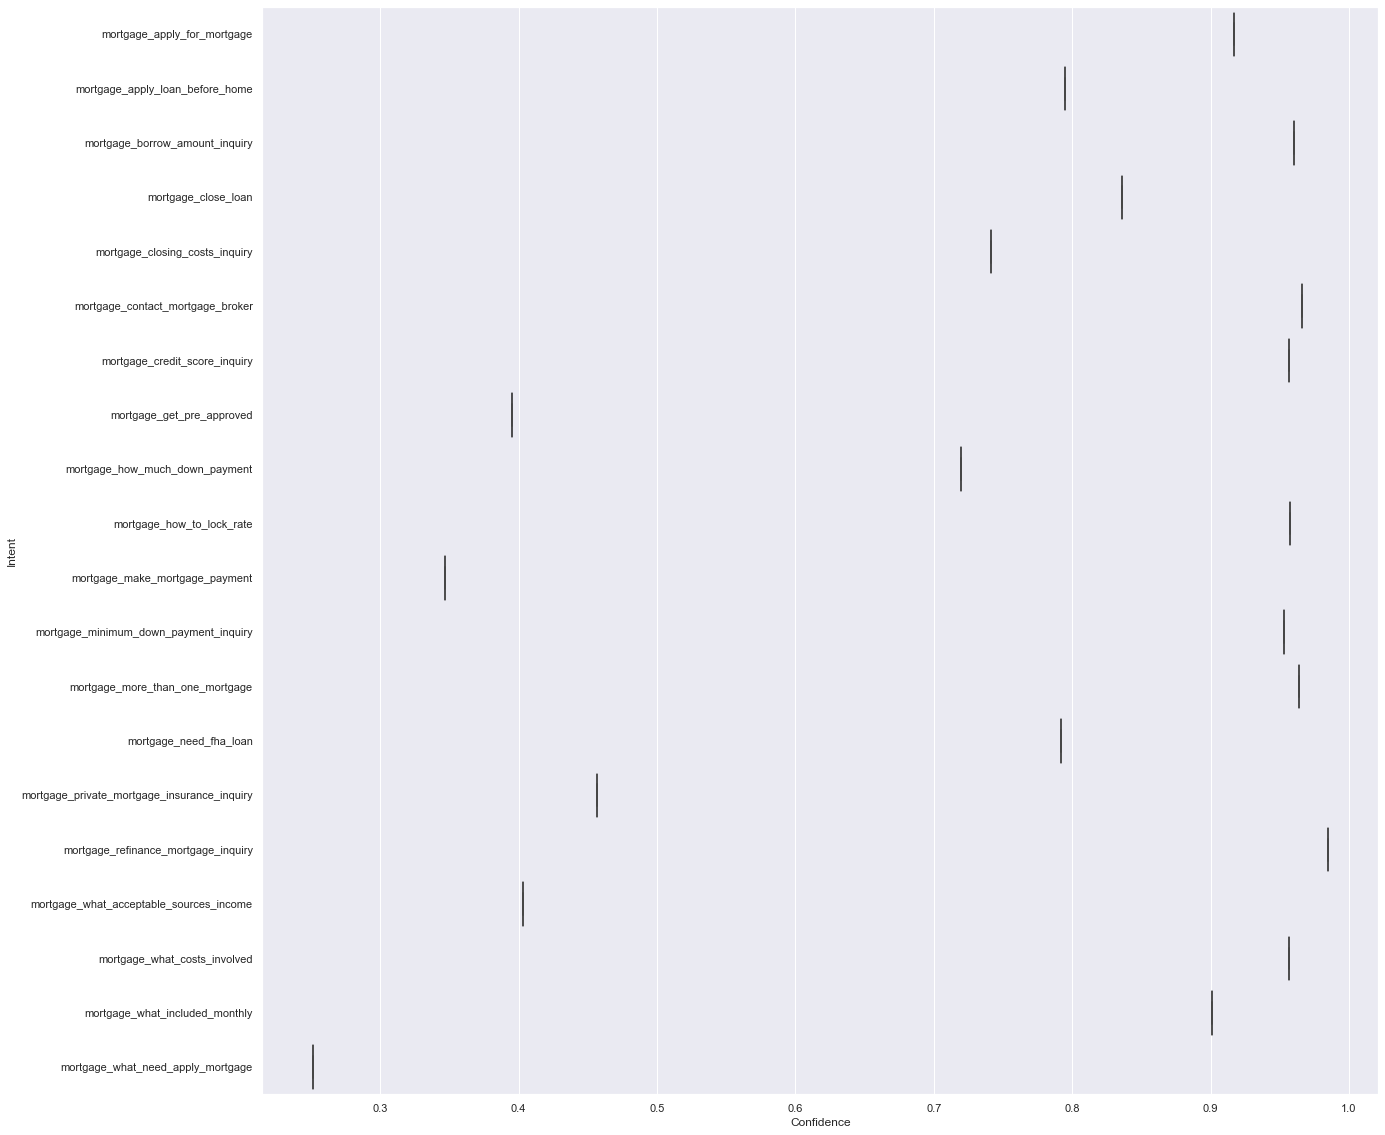

In [20]:
BoxPlot = {
    "Intent": (IntentList),
    "Confidence": (ConfidenceList)
}

BoxPlot = pd.DataFrame(BoxPlot)
sns.boxplot( y=BoxPlot["Intent"], x=BoxPlot["Confidence"], fliersize=0.1);

## Definition Calculation

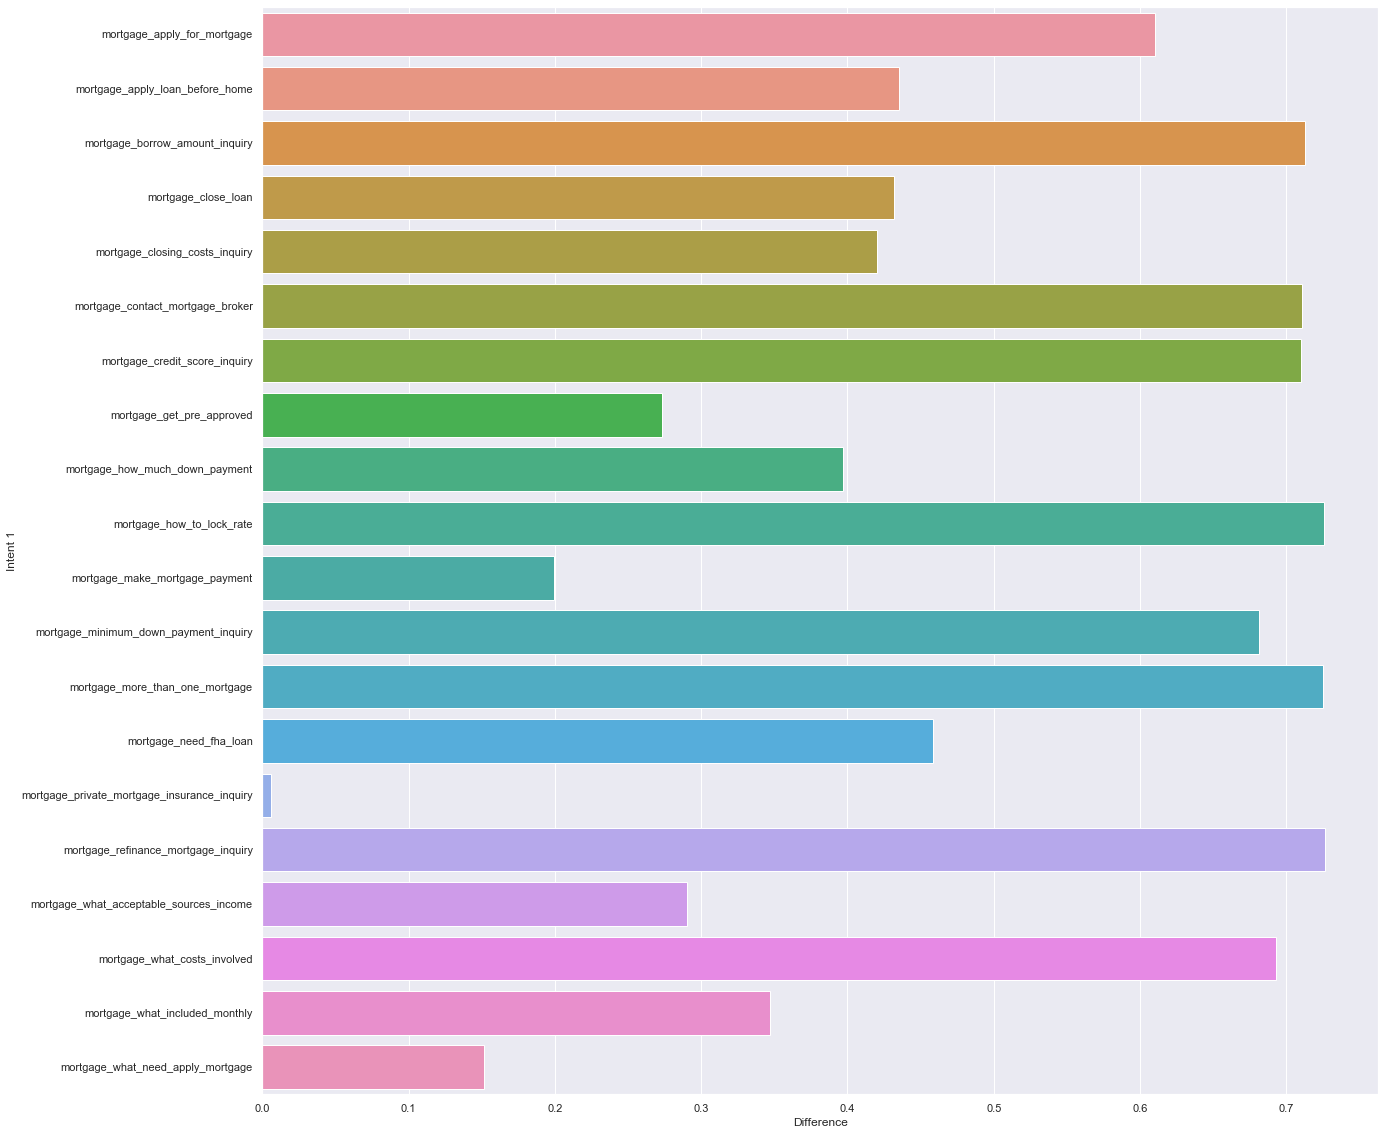

In [18]:
DefinitionDF = DifferentialDF.groupby('Intent 1')['Difference'].mean().sort_values(ascending=False)
BarPlot = sns.barplot(y = DifferentialDF['Intent 1'], x = DifferentialDF['Difference'], errwidth=0)

## Save the updated files to include the latest scores

In [19]:
#Create the Regression File to reference in the future

RegressionDict = { 'Question':(QuestionList),
           'Expected':(ExpectedList),
           'Intent':(IntentList),
           'Confidence':(ConfidenceList),
           'Matched': (MatchList),
           'Previous Score':(ScoreList)
               }
finaldf = pd.DataFrame(RegressionDict)


RegressionLogDF.to_csv('RegressionLog.csv', index=False)
DifferentialDF.to_csv('Differential.csv', index=False)